In [ ]:
# RUN DOCKER

import os
import subprocess
import time

import numpy as np
sys.path.insert(0, r"../model/")
from utils import dataLoader, saliency, visualize
from model import NativeSpacemodel
import pandas as pd
import tensorflow as tf

In [1]:
def format_time(seconds):
    hrs = int(seconds // 3600)
    mins = int((seconds % 3600) // 60)
    secs = seconds % 60
    return f"{hrs:02d}:{mins:02d}:{secs:06.3f}"

start = time.time()

DATA_DIR = "/data"

subject_id = '001'

cmd = [
    "docker", "compose", "run", "--rm",
    "freesurfer",
    "recon-all",
    "-i", f"/input/{subject_id}.nii",  # or .mgz if your input is already MGZ
    "-s", subject_id,
    "-all", # runs autorecon1,2,3 and produces brain.mgz
]

subprocess.run(cmd, check=True)

end = time.time()
elapsed = end - start

print("Time elapsed:", format_time(elapsed))

Time elapsed: 03:29:47.685


In [20]:
## filePaths - replace with your file paths - should point to brain.mgz
filePaths = ["../subjects/002/mri/brain.mgz"] 
csvLocation = ""

csvName = "BAtest.csv"

# limit TF memory usage
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print("Could not limit memory usage")

BAPredictor = NativeSpacemodel.get_model()
modelWeights = "../model/model/NativeSpaceWeight.h5"
BAPredictor.load_weights(modelWeights)

brains = dataLoader.dataLoader(filePaths)

[n, h, w, d] = np.shape(brains)
print("Loaded ", n, " brains")

# make sure the prepocessed brains have 128^3 volumes  
assert h==w==d == 128

predictions = BAPredictor.predict(brains)
dfBA = pd.DataFrame(predictions)
dfBA.columns = ["BA"]
dfBA.to_csv(csvLocation+csvName)

Could not limit memory usage
Loaded  1  brains
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


In [30]:
print('Estimated Biological Brain Age:', dfBA['BA'][0], 'yrs')

Estimated Biological Brain Age: 81.50946 yrs


(1, 128, 128, 128) (1, 128, 128, 128)


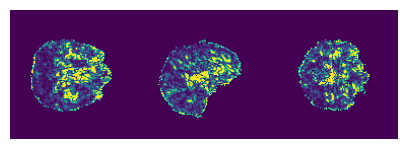

In [21]:
def contrast_stretch(volume, low=1, high=99):
    """
    Linearly stretch contrast based on percentiles.
    volume: 3D numpy array
    low, high: percentiles to clip (avoid extreme noise)
    """
    p_low, p_high = np.percentile(volume, (low, high))
    stretched = np.clip((volume - p_low) / (p_high - p_low), 0, 1)
    return stretched

sMaps = saliency.saliencyMap(BAPredictor, brains)
print(np.shape(sMaps), np.shape(brains))

# post-process saliency 
sMaps = contrast_stretch(saliency.postProcess(sMaps, brains))

visualize.plot3Views(sMaps, slice1=64)